# Named Entity Recognition using Conditional Random Fields (CRFs)

Named Enity Recognition is one of the most common NLP problems. The goal is classify named entities in text into pre-defined categories such as the names of persons, organizations, locations, expressions of times, quantities, monetary values, percentages, etc. What can you use it for? Here are a few ideas - social media, chatbot, customer support tickets, survey responses, and data mining!

Let's start by importing some packages.

In [1]:
files_path = "./"

In [ ]:
!pip install sklearn-crfsuite

In [23]:
import pandas as pd
import sklearn_crfsuite
from sklearn_crfsuite import CRF
from sklearn_crfsuite.metrics import flat_f1_score
from sklearn_crfsuite.metrics import flat_classification_report
import matplotlib.pyplot as plt
% matplotlib inline

# Data

Let's take a look at data. [Annotated Corpus for Named Entity Recognition](https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus?select=ner_dataset.csv)

In [6]:
data = pd.read_csv(f"{files_path}ner_dataset.csv", encoding="latin1")
data = data.fillna(method="ffill")

print("Number of sentences: ", len(data.groupby(['Sentence #'])))

words = list(set(data["Word"].values))
n_words = len(words)
print("Number of words in the dataset: ", n_words)

tags = list(set(data["Tag"].values))
print("Tags:", tags)
n_tags = len(tags)
print("Number of Labels: ", n_tags)

print("What the dataset looks like:")
# Show the first 10 rows
data.head(n=10)

Number of sentences:  47959
Number of words in the dataset:  35178
Tags: ['I-art', 'I-org', 'I-nat', 'B-art', 'O', 'I-gpe', 'I-tim', 'B-nat', 'I-geo', 'B-gpe', 'B-tim', 'I-eve', 'B-geo', 'I-per', 'B-per', 'B-org', 'B-eve']
Number of Labels:  17
What the dataset looks like:


,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [7]:
class SentenceGetter(object):
    """Class to Get the sentence in this format:
    [(Token_1, Part_of_Speech_1, Tag_1), ..., (Token_n, Part_of_Speech_1, Tag_1)]"""
    def __init__(self, data):
        """Args:
            data is the pandas.DataFrame which contains the above dataset"""
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        """Return one sentence"""
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None
        
getter = SentenceGetter(data)
sent = getter.get_next()
print('This is what a sentence looks like:')
print(sent)

This is what a sentence looks like:
[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')]


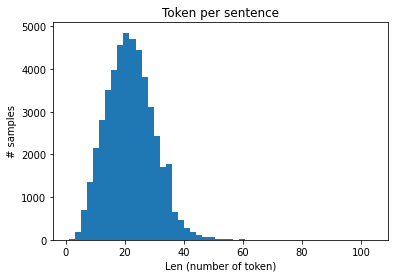

In [10]:
# Get all the sentences
sentences = getter.sentences

# Plot sentence by lenght
plt.hist([len(s) for s in sentences], bins=50)
plt.title('Token per sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

# Data Preprocessing
Before feeding the data into the model, we have to preprocess the text.


In [15]:
from sklearn.model_selection import train_test_split
train_sents, test_sents = train_test_split(sentences, test_size=0.1)

## Feature Preparation for CRF

POS tags can be seen as pre-extracted features. Let’s extract more features (word parts, simplified POS tags, lower / title / upper flags, features of nearby words) and convert them to sklear-crfsuite format - each sentence should be converted to a list of dicts. This is a very simple baseline; you certainly can do better.

In [16]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True

    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

X_train = [sent2features(s) for s in train_sents]
y_train = [sent2labels(s) for s in train_sents]

X_test = [sent2features(s) for s in test_sents]
y_test = [sent2labels(s) for s in test_sents]

This is how features extracted from a single token look like:

In [19]:
X_train[0][1]

{'+1:postag': 'VBD',
 '+1:postag[:2]': 'VB',
 '+1:word.istitle()': False,
 '+1:word.isupper()': False,
 '+1:word.lower()': 'joined',
 '-1:postag': 'NNP',
 '-1:postag[:2]': 'NN',
 '-1:word.istitle()': True,
 '-1:word.isupper()': False,
 '-1:word.lower()': 'mr.',
 'bias': 1.0,
 'postag': 'NNP',
 'postag[:2]': 'NN',
 'word.isdigit()': False,
 'word.istitle()': True,
 'word.isupper()': False,
 'word.lower()': 'kim',
 'word[-3:]': 'Kim'}

# Train a CRF model

Once we have features in a right format we can train a linear-chain CRF (Conditional Random Fields) model using sklearn_crfsuite.CRF

In [20]:
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=20,
    all_possible_transitions=False,
)
crf.fit(X_train, y_train);

## Evaluating the model  performance:

In [ ]:
#Predicting on the test set.
y_pred = crf.predict(X_test)

In [24]:
f1_score = flat_f1_score(y_test, y_pred, average = 'weighted')
print(f1_score)

0.9517897117558456


In [25]:
report = flat_classification_report(y_test, y_pred)
print(report)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00        49
       B-eve       0.00      0.00      0.00        27
       B-geo       0.75      0.89      0.81      3749
       B-gpe       0.88      0.83      0.86      1620
       B-nat       0.00      0.00      0.00        32
       B-org       0.74      0.59      0.65      1962
       B-per       0.76      0.72      0.74      1698
       B-tim       0.90      0.73      0.81      1996
       I-art       0.00      0.00      0.00        32
       I-eve       0.00      0.00      0.00        20
       I-geo       0.66      0.66      0.66       744
       I-gpe       0.00      0.00      0.00        32
       I-nat       0.00      0.00      0.00        12
       I-org       0.70      0.65      0.67      1557
       I-per       0.75      0.89      0.81      1692
       I-tim       0.72      0.58      0.64       690
           O       0.99      0.99      0.99     88794

    accuracy              

# References

https://pypi.org/project/sklearn-crfsuite/

https://eli5.readthedocs.io/en/latest/tutorials/sklearn_crfsuite.html

https://github.com/Akshayc1/named-entity-recognition